# Анализ убытков мобильного приложения

## Цель исследования

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.

Необходимо изучить:

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

### Описание данных  

В вашем распоряжении три датасета с данными о пользователях, привлечённых с 1 мая по 27 октября 2019 года:  

Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта:  
•	`User Id` — уникальный идентификатор пользователя,  
•	`Region` — страна пользователя,  
•	`Device` — тип устройства пользователя,  
•	`Channel` — идентификатор источника перехода,  
•	`Session Start` — дата и время начала сессии,  
•	`Session End` — дата и время окончания сессии.  


Файл `orders_info_short.csv` — хранит информацию о заказах:  
•	`User Id` — уникальный идентификатор пользователя,  
•	`Event Dt` — дата и время покупки,  
•	`Revenue` — сумма заказа.  

Файл `costs_info_short.csv` — содержит информацию о расходах на рекламу:  
•	`dt` — дата проведения рекламной кампании,  
•	`Channel` — идентификатор рекламного источника,  
•	`costs` — расходы на эту кампанию.  


# Оглавление


* [1.  Загрузка данных и подготовка к анализу](#article1)
* [2.  Создание функций для расчёта и анализа LTV, ROI, удержания и конверсии](#article2)
* [3.  Исследовательский анализ данных](#article3)
    * [3.1  cоставление пользовательских профилей](#subart31)
    * [3.2  анализ пользователей по регионам](#subart32)
    * [3.3  анализ пользователей по устройствам](#subart33)
    * [3.4  анализ пользователей по каналам привлечения](#subart34)
* [4.  Маркетинг](#article4)
    * [4.1  анализ динамики затрат и привлеченных пользователей](#subart41)
    * [4.2  анализ затрат по каналам](#subart42)
    * [4.3  анализ затрат по странам](#subart43)
    * [4.4  анализ затрат по устройствам](#subart44)
* [5.  Оценка окупаемости рекламы](#article5)
    * [5.1  Анализ основных показателей окупаемости](#subart51)
    * [5.2  Оценка окупаемости рекламы по регионам](#subart52)
    * [5.3  Оценка окупаемости рекламы по устройствам](#subart53)
    * [5.4  Оценка окупаемости рекламы по каналам](#subart54)
* [6.  Выводы и рекомендации](#article6)

<a id="article1"></a>
## Загрузка данных и подготовка к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
visits.duplicated().sum()

0

In [5]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.dtypes

user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

In [7]:
orders = pd.read_csv('/datasets/orders_info_short.csv')
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [9]:
orders.duplicated().sum()

0

In [10]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [11]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.dtypes

user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

In [12]:
costs = pd.read_csv('/datasets/costs_info_short.csv')
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [13]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [14]:
costs.duplicated().sum()

0

In [15]:
costs.columns = costs.columns.str.lower().str.replace(' ', '_')
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

In [16]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 
costs.dtypes

dt          object
channel     object
costs      float64
dtype: object

Данные загружены и готовы к работе.  
Предоставленные файлы не содержат дубликатов и пропусков.  
В рамках подготовки названия колонок были приведены к виду: с маленькой буквы, пробелы заменены на нижнее подчеркивание.
Формат колонок, содержащих даты, преобразован к datetime

<a id="article2"></a>
## Создание функций для расчёта и анализа LTV, ROI, удержания и конверсии.

Зададим функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [62]:
def get_profiles(sessions, orders, ad_costs):
    
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start']).groupby('user_id')
        .agg({
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            })
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['week'] = profiles['first_ts'].astype('datetime64[W]')

    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [18]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    dimensions = ['payer'] + dimensions

    last_suitable_acquisition_date = observation_date
    
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)        
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on='user_id', how='left')
    
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time

In [19]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
                    
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (purchases.sort_values(by=['user_id', 'event_dt'])
                    .groupby('user_id')
                    .agg({'event_dt': 'first'})
                    .reset_index())

    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on='user_id', how='left')
        
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
      
        result = result.fillna(0).cumsum(axis = 1)
        
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
       
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time 

In [20]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
 
    result_raw = result_raw.merge(purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
        
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']


    def group_by_dimensions(df, dims, horizon_days):

        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        result = result.fillna(0).cumsum(axis=1)

        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
 
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
    
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [21]:
def filter_data(df, window):

    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [22]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))
    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')    
    
    ax3 = plt.subplot(2, 2, 3)

    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]

    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)

    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [23]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
            name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [24]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon,window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))
    
    plt.tight_layout()
    plt.show() 

<a id="article3"></a>
## Исследовательский анализ данных

<a id="subart31"></a>
### cоставление  пользовательских профилей

In [25]:
profiles = get_profiles(visits, orders, costs)
profiles.head(10)

,user_id,first_ts,channel,device,region,dt,month,week,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,2019-05-02,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,2019-07-04,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,2019-09-26,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,2019-08-22,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,2019-09-26,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,2019-05-09,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,2019-08-15,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,2019-06-27,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,2019-05-09,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,2019-05-09,False,0.250435


In [26]:
min_date = profiles['first_ts'].min()
min_date

Timestamp('2019-05-01 00:00:41')

In [27]:
max_date = profiles['first_ts'].max()
max_date

Timestamp('2019-10-27 23:59:04')

In [28]:
profiles['user_id'].nunique()

150008

In [29]:
profiles['payer'].sum()

8881

In [30]:
(profiles['payer'].mean()*100).round(1)

5.9

Предоставленный массив  данных содержит информацию о привлеченных пользователях за период с 1 мая 2019 по 27 октября 2019 в соотетствии с ТЗ.  
Всего есть данные по 150008 пользовательским профилям. Из них платящими пользователями являются 8881, что составляет 5.9% от всех пользователей.

<a id="subart32"></a>
### анализ пользователей по регионам

Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [31]:
reg_profile = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'sum'}).sort_values(by='user_id', ascending=False)
reg_profile['region_share']=(reg_profile['user_id']/reg_profile['user_id'].sum()).map(lambda x: '{0:.1%}'.format(x))
reg_profile['payer_ratio']=(reg_profile['payer']/reg_profile['user_id']).map(lambda x: '{0:.1%}'.format(x))
reg_profile

,user_id,payer,region_share,payer_ratio
region,,,,
United States,100002,6902,66.7%,6.9%
UK,17575,700,11.7%,4.0%
France,17450,663,11.6%,3.8%
Germany,14981,616,10.0%,4.1%


Наибольшее число пользователей приходит с рынка США - 67% доли.   
Остальные пользователи равномерно распределяются между остальными рынками: Англия, Франция и Германия  - по 10..12 % доли.   
Для рынка США так же харакретна наибольшая доля платящей аудитории - 6,9% , что существенно выше остальные рынков, где  ~4 % платящей аудитории.

<a id="subart33"></a>
### анализ пользователей по устройствам

Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [32]:
device_profile = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'sum'}).sort_values(by='user_id', ascending=False)
device_profile['device_share'] = (device_profile['user_id']/device_profile['user_id'].sum()).map(lambda x: '{0:.1%}'.format(x))
device_profile['payer_ratio']=(device_profile['payer']/device_profile['user_id']).map(lambda x: '{0:.1%}'.format(x))
device_profile

,user_id,payer,device_share,payer_ratio
device,,,,
iPhone,54479,3382,36.3%,6.2%
Android,35032,2050,23.4%,5.9%
PC,30455,1537,20.3%,5.0%
Mac,30042,1912,20.0%,6.4%


Cреди пользователей проекта есть уклон в сторону IPhone (36% всех устройств), остальные устройства приедствлены в равном соотношении (~ по 20%).    
Платящая аудитории распределяется по устройствам примерно равномерно - 5..6%.   

<a id="subart34"></a>
### анализ пользователей по каналам привлечения

Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [33]:
channel_profile = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer':'sum'}).sort_values(by='user_id', ascending=False)
channel_profile['channel_share'] = (channel_profile['user_id']/channel_profile['user_id'].sum()).map(lambda x: '{0:.1%}'.format(x))
channel_profile['payer_ratio']=(channel_profile['payer']/channel_profile['user_id']).map(lambda x: '{0:.1%}'.format(x))
channel_profile

,user_id,payer,channel_share,payer_ratio
channel,,,,
organic,56439,1160,37.6%,2.1%
FaceBoom,29144,3557,19.4%,12.2%
TipTop,19561,1878,13.0%,9.6%
OppleCreativeMedia,8605,233,5.7%,2.7%
LeapBob,8553,262,5.7%,3.1%
WahooNetBanner,8553,453,5.7%,5.3%
RocketSuperAds,4448,352,3.0%,7.9%
MediaTornado,4364,156,2.9%,3.6%
YRabbit,4312,165,2.9%,3.8%


Больше всего пользователей пришло с органического поиска (38%). Но, учитывая, что доля платящих пользователей с этого канала привлечения самая низкая, по количеству платящих пользователей он только на 3 месте после FaceBoom и TipTop.

Лидерами по доле платящей аудитории являются: FaceBoom, AdNonSense, lambdaMediaAds и  TipTop

<a id="article4"></a>
## Маркетинг

In [34]:
costs['costs'].sum()

105497.30000000002

<a id="subart41"></a>
### анализ динамики затрат и привлеченных пользователей

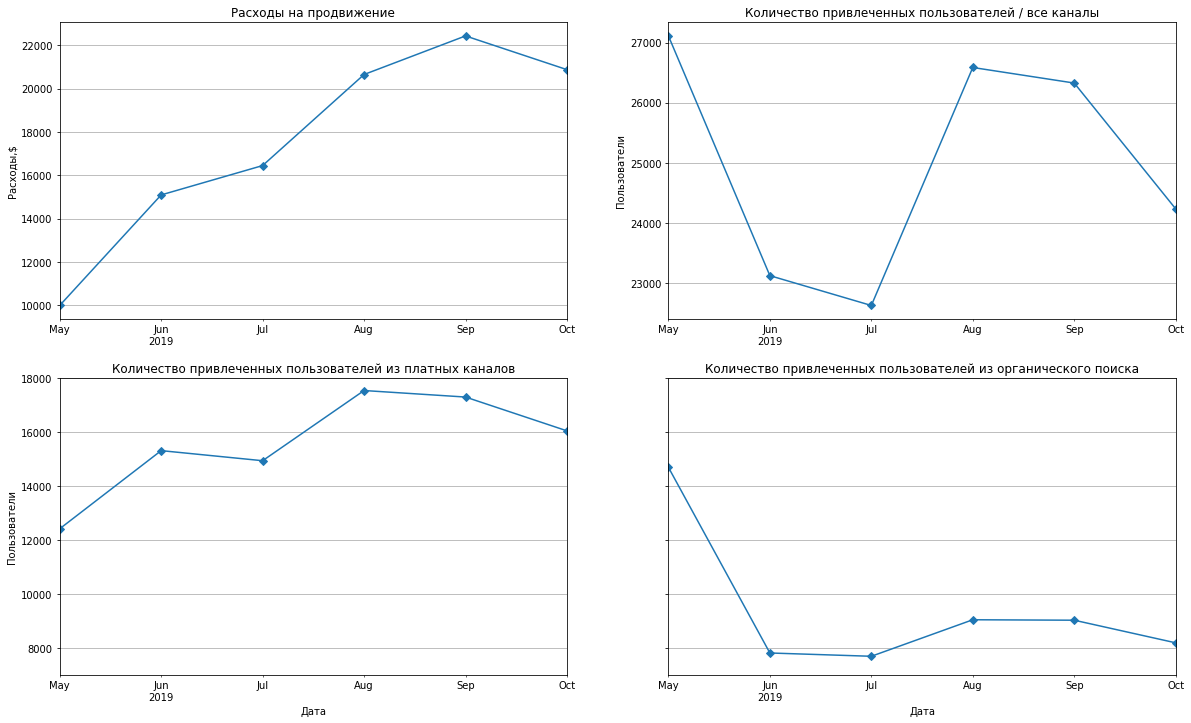

In [35]:
plt.figure(figsize=(20, 12))

ax1 = plt.subplot(2, 2, 1)
profiles.groupby('month')['acquisition_cost'].sum().plot(grid=True, marker="D")
plt.xlabel('')
plt.ylabel('Расxоды,$')
plt.title('Расходы на продвижение')


ax2 = plt.subplot(2, 2, 2)
profiles.groupby('month')['user_id'].nunique().plot(grid=True, marker="D")
plt.xlabel('')
plt.ylabel('Пользователи')
plt.title('Количество привлеченных пользователей / все каналы')

ax3 = plt.subplot(2, 2, 3)
profiles.query('channel != "organic"').groupby('month')['user_id'].nunique().plot(grid=True, marker="D")
plt.ylim(7000,18000)
plt.xlabel('Дата')
plt.ylabel('Пользователи')
plt.title('Количество привлеченных пользователей из платных каналов')


ax4 = plt.subplot(2, 2, 4, sharey=ax3)
profiles.query('channel == "organic"').groupby('month')['user_id'].nunique().plot(grid=True, marker="D")
plt.xlabel('Дата')
plt.ylabel('Пользователи')
plt.title('Количество привлеченных пользователей из органического поиска');

Динамика привлеченных пользователей из *платных* каналов соответствует динамике прироста расходов на привлечение.  
В Мае количество привлеченных *органических* пользователей было выше количества пользователй пришедших из платных каналов, затем в Июне количество *органических* пользователей значимо снизилось.   

Необходимо дополнительно исследовать причины снижения *органических* пользователей. 
Причины могут быть разнообразные:   
проблемы в СЕО оптимизации,   
или снижение поисковых запросов под влиянием иных факторов, например, сокращение поддержки в других (офлайн) каналах продвижения, усиление активности конкурентов и пр.


<a id="subart42"></a>
### анализ затрат по  каналам

In [36]:
cac_avg = (costs['costs'].sum()/profiles.query('channel != "organic"')['user_id'].nunique()).round(2)
cac_avg

1.13

In [37]:
costs_agg = profiles.query('channel != "organic"').groupby('channel').agg({'acquisition_cost':'sum', 'user_id':'nunique'})\
                     .sort_values(by = 'acquisition_cost',ascending=False).rename(columns={'user_id': 'ftb'}).reset_index()
costs_agg['cac'] = (costs_agg['acquisition_cost']/costs_agg['ftb']).round(2)
costs_agg ['sos'] = (costs_agg['acquisition_cost']/costs_agg['acquisition_cost'].sum()).map(lambda x: '{0:.1%}'.format(x))
costs_agg['ftb_']=(costs_agg['ftb']/costs_agg['ftb'].sum()).map(lambda x: '{0:.1%}'.format(x))
costs_agg

,channel,acquisition_cost,ftb,cac,sos,ftb_
0,TipTop,54751.30,19561,2.80,51.9%,20.9%
1,FaceBoom,32445.60,29144,1.11,30.8%,31.1%
2,WahooNetBanner,5151.00,8553,0.60,4.9%,9.1%
3,AdNonSense,3911.25,3880,1.01,3.7%,4.1%
4,OppleCreativeMedia,2151.25,8605,0.25,2.0%,9.2%
5,RocketSuperAds,1833.00,4448,0.41,1.7%,4.8%
6,LeapBob,1797.60,8553,0.21,1.7%,9.1%
7,lambdaMediaAds,1557.60,2149,0.72,1.5%,2.3%
8,MediaTornado,954.48,4364,0.22,0.9%,4.7%
9,YRabbit,944.22,4312,0.22,0.9%,4.6%


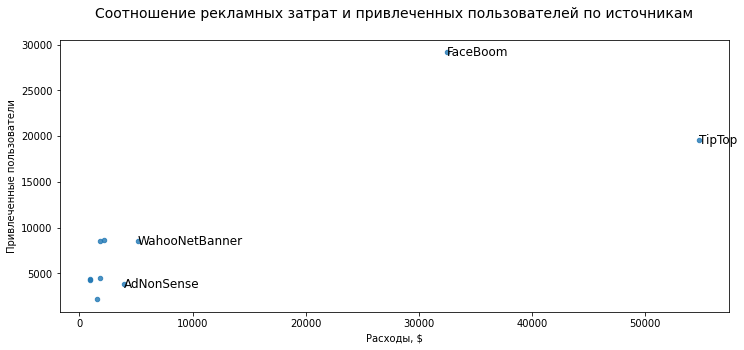

In [38]:
ax = costs_agg.plot(kind = 'scatter', x='acquisition_cost', y='ftb', figsize=(12, 5), alpha=0.8)
plt.title('Соотношение рекламных затрат и привлеченных пользователей по источникам\n',  fontsize=14)
plt.xlabel("Расходы, $")
plt.ylabel("Привлеченные пользователи")
for i, row in costs_agg.head(4).iterrows():
    ax.annotate(row['channel'], (row['acquisition_cost'], row['ftb']), fontsize=12, va='center', ha='left');

Лидерами по рекламным инвестициям являются TipTop и FaceBoom. Суммарно на эти каналы приходится 82% всех рекламных затрат.

TipTop и FaceBoom так же являются лидерами по общему количеству привлеченных пользователей - 52% пользователей пришли с этих каналов (в разрезе платных источников привлечения, исключая органику)

У TipTop доля привлеченных пользователей соответствует доля расходов в рекламу, а у FaceBoom - расходы на рекламу несоизмеримо выше доли привлеченных пользователей

На графике сопоставления рекламных затрат  и количества привлеченных пользователей наглядно видно, что инветиции в TipTop менее эффективны чем в FaceBoom: при большем объеме инвестиций, количество привлеченных пользователей на треть меньше.   
Cac у TipTop в 2,5 раза выше, чем у FaceBoom.

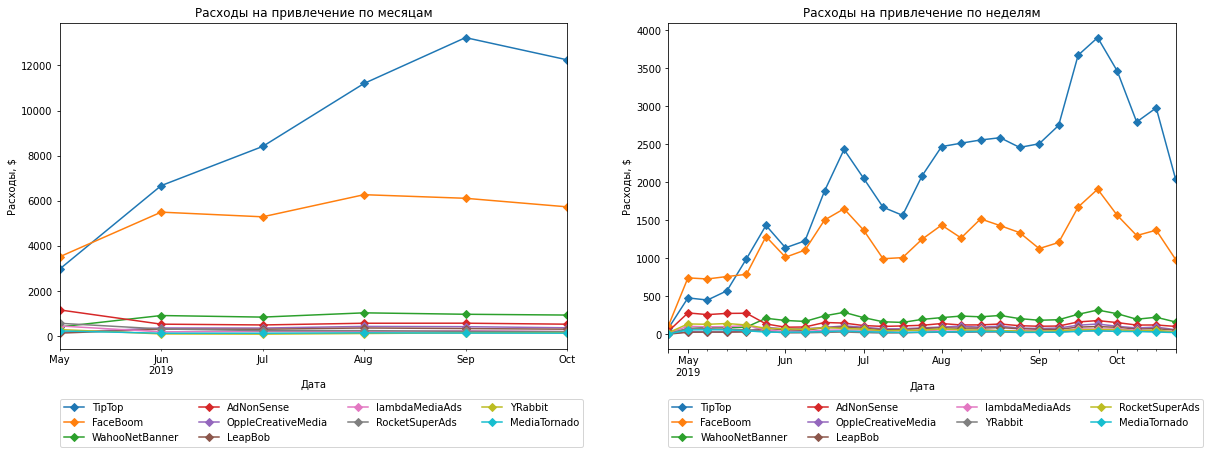

In [39]:
costs['Расходы на привлечение по месяцам'] = costs['dt'].astype('datetime64[M]')
costs['Расходы на привлечение по неделям'] = costs['dt'].astype('datetime64[W]')

columns = ['Расходы на привлечение по месяцам', 'Расходы на привлечение по неделям']

plt.subplots(figsize = (20,6))
for i, col in enumerate(columns):
    costs.pivot_table(index = 'channel', columns = col, values = 'costs', 
                      aggfunc = 'sum').sort_values(by = costs[col].max(), ascending = False)\
                      .T.plot(ax = plt.subplot(1, 2, i + 1),  marker="D")
    plt.title(col)
    plt.xlabel('Дата')
    plt.ylabel('Расходы, $')
    plt.legend(ncol=4, bbox_to_anchor=(0, -0.3), loc='lower left', borderaxespad=0)
plt.show()


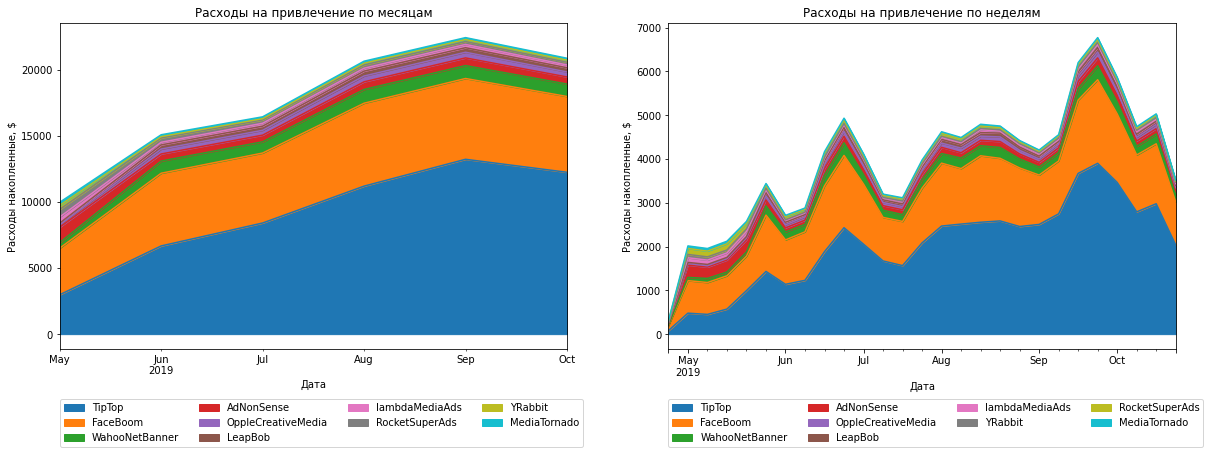

In [40]:
# расходы с накоплением
columns = ['Расходы на привлечение по месяцам', 'Расходы на привлечение по неделям']

plt.subplots(figsize = (20,6))
for i, col in enumerate(columns):
    costs.pivot_table(index = 'channel', columns = col, values = 'costs', 
                      aggfunc = 'sum').sort_values(by = costs[col].max(), ascending = False)\
                      .T.plot.area(ax = plt.subplot(1, 2, i + 1))
    plt.title(col)
    plt.xlabel('Дата')
    plt.ylabel('Расходы накопленные, $')
    plt.legend(ncol=4, bbox_to_anchor=(0, -0.3), loc='lower left', borderaxespad=0)
plt.show()

В динамике видно, что расходы лидеров увеличиваются, и задают общий рост инвестиций:   
инвестиции на FaceBoom выросли в Июне и далее поддерживались на стабильном уровне,   
инвестиции на TipTop продолжали нарастать каждый месяц.   
Инвестиции в остальные каналы держатся на постоянном уровне.  

<a id="subart43"></a>
### анализ затрат по странам

In [41]:
costs_agg_reg = profiles.query('channel != "organic"').groupby('region').agg({'acquisition_cost':'sum', 'user_id':'nunique'})\
                     .sort_values(by = 'acquisition_cost',ascending=False).rename(columns={'user_id': 'ftb'}).reset_index()
costs_agg_reg['cac'] = (costs_agg_reg['acquisition_cost']/costs_agg_reg['ftb']).round(2)
costs_agg_reg ['sos'] = (costs_agg_reg['acquisition_cost']/costs_agg_reg['acquisition_cost'].sum()).map(lambda x: '{0:.1%}'.format(x))
costs_agg_reg['ftb_']=(costs_agg_reg['ftb']/costs_agg_reg['ftb'].sum()).map(lambda x: '{0:.1%}'.format(x))
costs_agg_reg

,region,acquisition_cost,ftb,cac,sos,ftb_
0,United States,90928.600000,61829,1.47,86.2%,66.1%
1,France,5075.973946,11058,0.46,4.8%,11.8%
2,UK,5068.502819,11154,0.45,4.8%,11.9%
3,Germany,4424.223235,9528,0.46,4.2%,10.2%


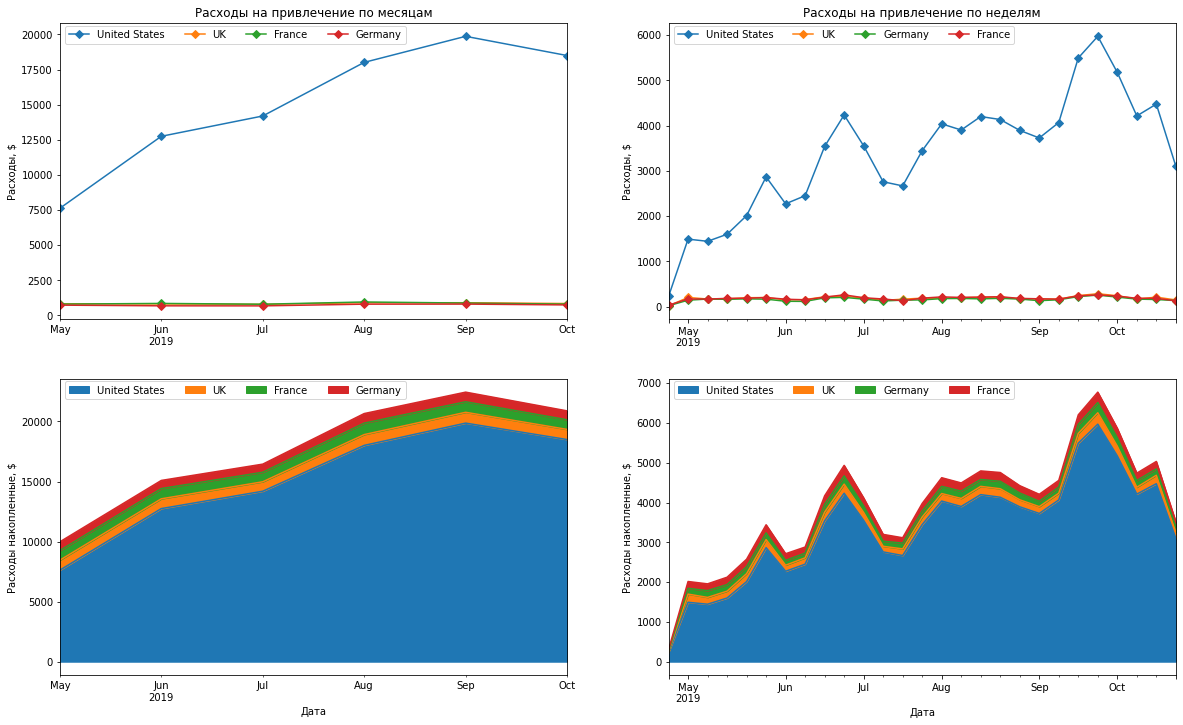

In [42]:
columns = ['month', 'week']

plt.subplots(figsize = (20,12))
for i, col in enumerate(columns):
    profiles.pivot_table(index = 'region', columns = col, values = 'acquisition_cost', 
                      aggfunc = 'sum').sort_values(by = profiles[col].max(), ascending = False)\
                      .T.plot(ax = plt.subplot(2, 2, i + 1),  marker="D", legend = False)
    if col == 'month':
        plt.title('Расходы на привлечение по месяцам')
    elif col == 'week':
        plt.title('Расходы на привлечение по неделям')    
        
    plt.ylabel('Расходы, $')  
    plt.xlabel('')
    plt.legend(ncol=4, bbox_to_anchor=(0.01, 0.93), loc='lower left', borderaxespad=0)
    
    profiles.pivot_table(index = 'region', columns = col, values = 'acquisition_cost', 
                      aggfunc = 'sum').sort_values(by = profiles[col].max(), ascending = False)\
                      .T.plot.area(ax = plt.subplot(2, 2, i + 3))
    
    plt.title = plt.title
    plt.ylabel('Расходы накопленные, $')   
    plt.xlabel('Дата')
    plt.legend(ncol=4, bbox_to_anchor=(0.01, 0.93), loc='lower left', borderaxespad=0)
plt.show()

Доля рекламных расходов на США составила 86%. На остальные страны расходы распределены равномерно (4..5%) .  
Доля расходов на рекламу США непропорционально выше доли привлеченных покупателей - 66%.   
Сас в США втрое выше в сравнении с европейскими странами.   
Расходы на рекламу в США постоянно прирастали, в остальных странах держались на постоянном уровне.

<a id="subart44"></a>
### анализ затрат по устройствам

In [43]:
costs_agg_dev = profiles.query('channel != "organic"').groupby('device').agg({'acquisition_cost':'sum', 'user_id':'nunique'})\
                     .sort_values(by = 'acquisition_cost',ascending=False).rename(columns={'user_id': 'ftb'}).reset_index()
costs_agg_dev['cac'] = (costs_agg_dev['acquisition_cost']/costs_agg_dev['ftb']).round(2)
costs_agg_dev ['sos'] = (costs_agg_dev['acquisition_cost']/costs_agg_dev['acquisition_cost'].sum()).map(lambda x: '{0:.1%}'.format(x))
costs_agg_dev['ftb_']=(costs_agg_dev['ftb']/costs_agg_dev['ftb'].sum()).map(lambda x: '{0:.1%}'.format(x))
costs_agg_dev

,device,acquisition_cost,ftb,cac,sos,ftb_
0,iPhone,43678.788251,33882,1.29,41.4%,36.2%
1,Mac,24094.537878,18693,1.29,22.8%,20.0%
2,Android,22460.629159,21841,1.03,21.3%,23.3%
3,PC,15263.344712,19153,0.80,14.5%,20.5%


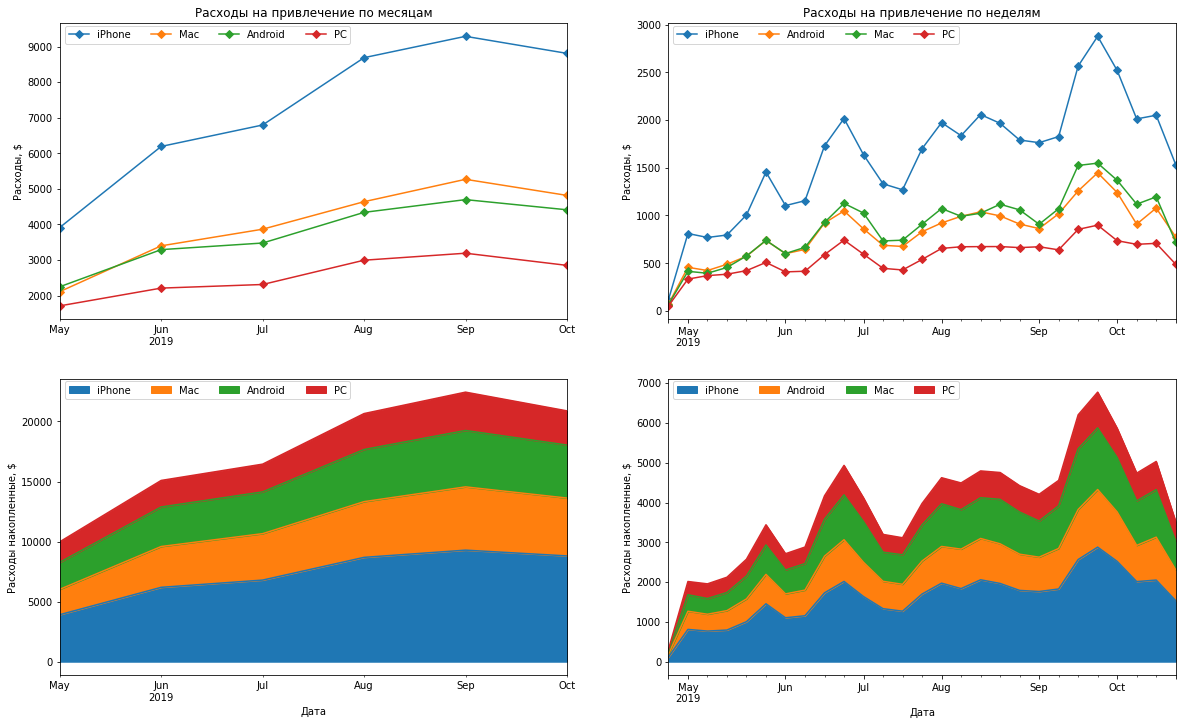

In [44]:
columns = ['month', 'week']

plt.subplots(figsize = (20,12))
for i, col in enumerate(columns):
    profiles.pivot_table(index = 'device', columns = col, values = 'acquisition_cost', 
                      aggfunc = 'sum').sort_values(by = profiles[col].max(), ascending = False)\
                      .T.plot(ax = plt.subplot(2, 2, i + 1),  marker="D", legend = False)
    if col == 'month':
        plt.title('Расходы на привлечение по месяцам')
    elif col == 'week':
        plt.title('Расходы на привлечение по неделям')    
        
    plt.ylabel('Расходы, $')  
    plt.xlabel('')
    plt.legend(ncol=4, bbox_to_anchor=(0.01, 0.93), loc='lower left', borderaxespad=0)
    
    profiles.pivot_table(index = 'device', columns = col, values = 'acquisition_cost', 
                      aggfunc = 'sum').sort_values(by = profiles[col].max(), ascending = False)\
                      .T.plot.area(ax = plt.subplot(2, 2, i + 3))
    
    plt.title = plt.title
    plt.ylabel('Расходы накопленные, $')   
    plt.xlabel('Дата')
    plt.legend(ncol=4, bbox_to_anchor=(0.01, 0.93), loc='lower left', borderaxespad=0)
plt.show()

На *IPhone* приходится самая высокая доля расходов - 41%. Нaименьшая доля расходов у *PC* - 14,5%    
У *IPhone* и *Mac* самый высокий Сac. Самый низкий Cac у *PC*.  

Расходы на рекламу прирастали на всех устройствах.

**Итоговый вывод**

TipTop и FaceBoom являются лидерами по рекламным инвестициям.   
TipTop и FaceBoom так же лидируют по количеству привлеченных пользователей.   

При этом  у TipTop и FaceBoom самая высокая стоимость привлечения (cac) по сравнению с остальными площадками.  
У FaceBoom - на уровне среднего, а у TipTop - в 2,5 раза выше.

TipTop постоянно наращивал свои расходы на привлечение.

Среди стран США является лидером по рекламных расходам с большим отрывом от европейских стран.   
При этом Cac США втрое больше других стран.
США постоянно наращивали инвестициив рекламу.

Далее, произведя анализ окупаемости затрат, оценим, оправданы ли такие инвестиции.

<a id="article5"></a>
## Оценка окупаемости рекламы


<a id="subart51"></a>
### Анализ основных показателей окупаемости

In [45]:
profiles = profiles.query('channel != "organic"')

In [46]:
observation_date = datetime(2019, 11, 1).date()  
horizon_days = 14  

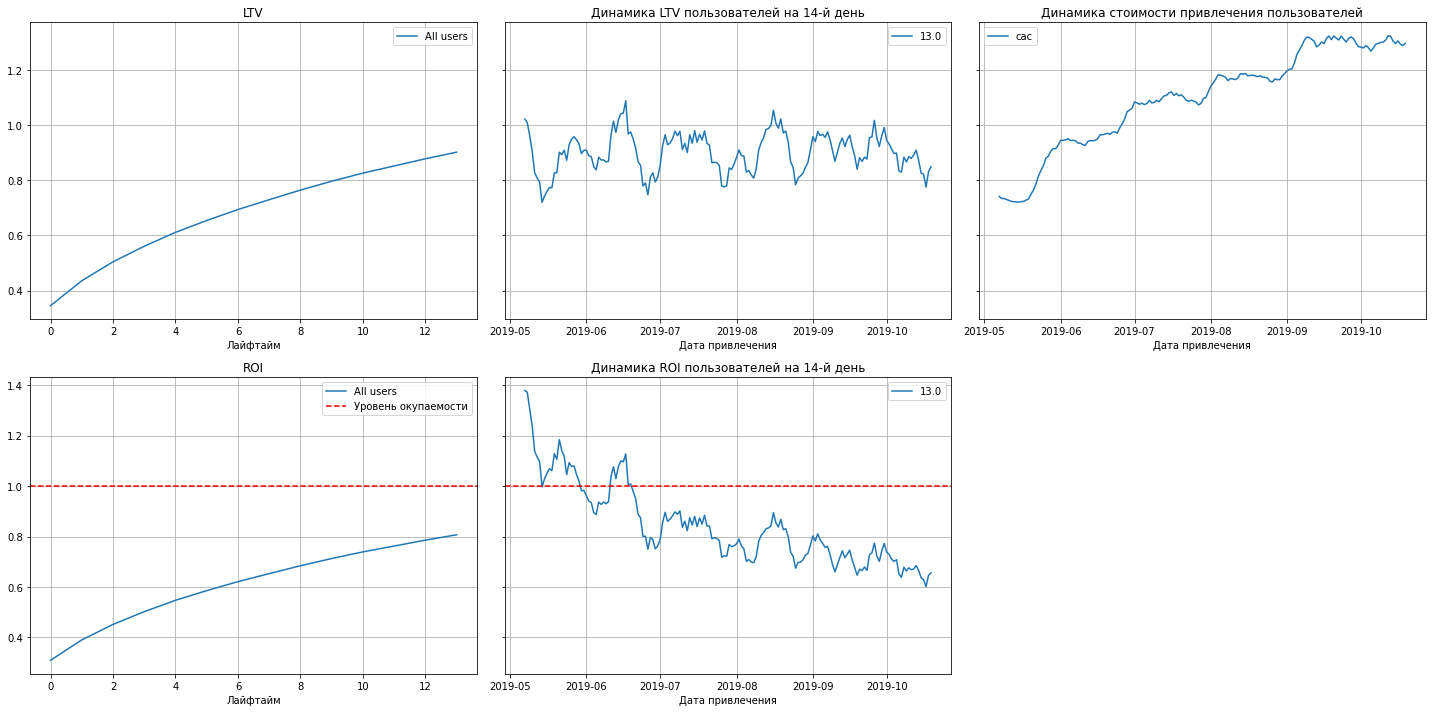

In [47]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

plot_ltv_roi (ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

ROI не достигает уровня окупаемости. За весь период существования проекта ROI был выше порога окупаемости только в Мае.   
Начная с Июня, окупаемость постоянно снижается.

LTV несмотря на колебания на протяжении всего периода держится на стабильном уровне и не имеет тенденций к росту или падению. Диапазон колебаний достаточно стабильный - от 0,8 до 1,0

На предыдущем этапе мы анализировали диинамику расходов на рекламу: расходы на рекламу прирастали на протяжении всего периода.    Однако, эффекта в виде увеличения LTV привлеченных пользователей мы не видим.

Результатом стало то, что стоимость привлечения имеет растущую динамику на протяжении всего периода развития проекта. 

**Итого: окупаемость приложения падает, на фоне роста рекламных инвестиций.   
Предварительно определим, что неэффективные инвестиции приводят к росту стоимости привлечения, а увеличения LTV при этим не происходит.**

Для поиска причин плохой окупаемости рассмотрим **конверсию** и **удержание**

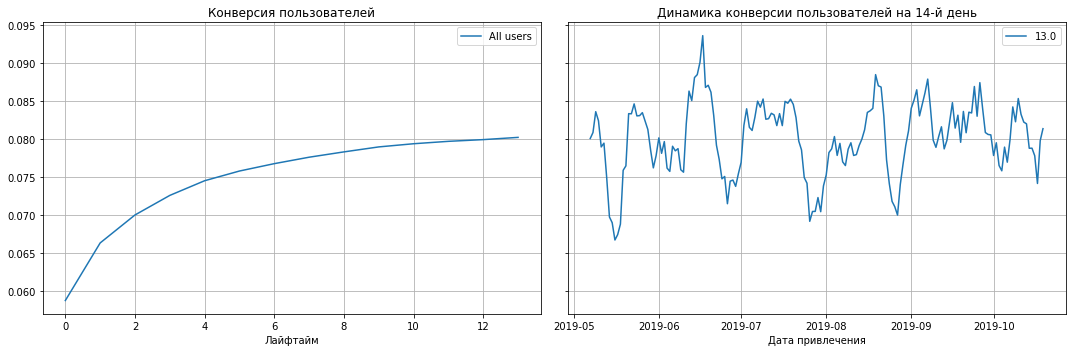

In [48]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Уровень конверсии достигает своего потолка к 11-му дню lifetime. Дальнейший прирост незначительный.   
Первый день приносит ~70% от общего количества привлеченных пользователей (от 6 % в 1-ый день до 8 % к 14-му дню). Т.е. в целом отклик аудитории довольно быстрый.

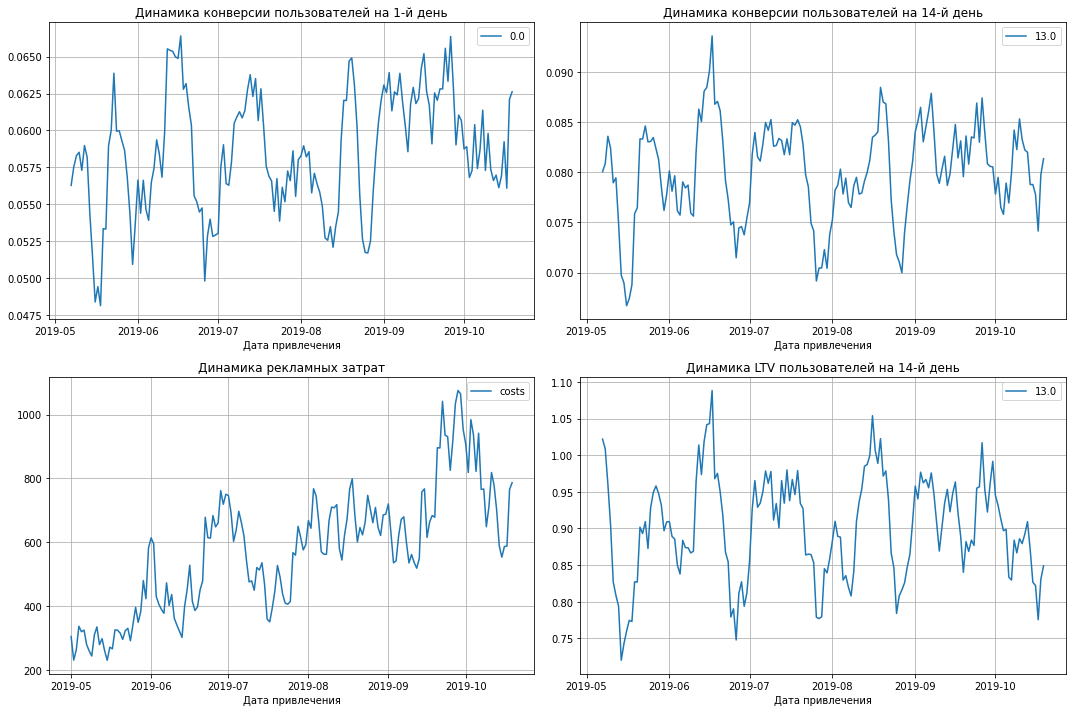

In [49]:
plt.figure(figsize=(15, 10))
window = 7    
max_date = observation_date - timedelta(days = horizon_days - 1)

ax1 = plt.subplot(2, 2, 1)

filtered_data = conversion_history.pivot_table( index='dt', values= 0 , aggfunc='mean')
filter_data(filtered_data, window).plot(grid=True, ax=ax1)
plt.xlabel('Дата привлечения')
plt.title('Динамика конверсии пользователей на 1-й день')


ax2 = plt.subplot(2, 2, 2)
filtered_data = conversion_history.pivot_table(index='dt', values=horizon_days - 1, aggfunc='mean')
filter_data(filtered_data, window).plot(grid=True, ax=ax2)
plt.xlabel('Дата привлечения')
plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon_days))

ax3 = plt.subplot(2, 2, 3)
filtered_data = costs.pivot_table(index = 'dt', values = 'costs', aggfunc = 'sum')
filtered_data.query('dt <= @max_date').plot(grid=True, ax=ax3)
plt.xlabel('Дата привлечения')
plt.title('Динамика рекламных затрат')

ax4 = plt.subplot(2, 2, 4)
filtered_data = ltv_history.pivot_table(index='dt', values=horizon_days - 1, aggfunc='mean')
filter_data(filtered_data, window).plot(grid=True, ax=ax4)
plt.xlabel('Дата привлечения')
plt.title('Динамика LTV пользователей на {}-й день'.format(horizon_days))
    
plt.tight_layout()
plt.show() 

**Выводы по анализу конверсии:**

Уровень конверсии достигает своего потолка к 11-му дню lifetime. Дальнейший прирост незначительный.
Первый день приносит ~70% от общего количества привлеченных пользователей (от 6 % в 1-ый день до 8 % к 14-му дню). Т.е. в целом отклик аудитории довольно быстрый.

Конверсия и LTV на 14-ый день - имеют очень схожую динамику. И конверсия и LTV на протяжении всего периода держатся на стабильном уровне.   
Т.е. пользователи, привлеченные в разные даты, совершают покупки и тратят схожим образом.   


Графики динамики конверсии и рекламных затрат имеют прямо противоположный вид: в периоды всплесков рекламной активности конверсии проседают, и наоборот. Это так же подтверждает предположение о неэффективности планирования рекламы.  
Т.е. увеличение инвестиций на определенном этапе дало рост, но планирование рекламы было неоптимальным.

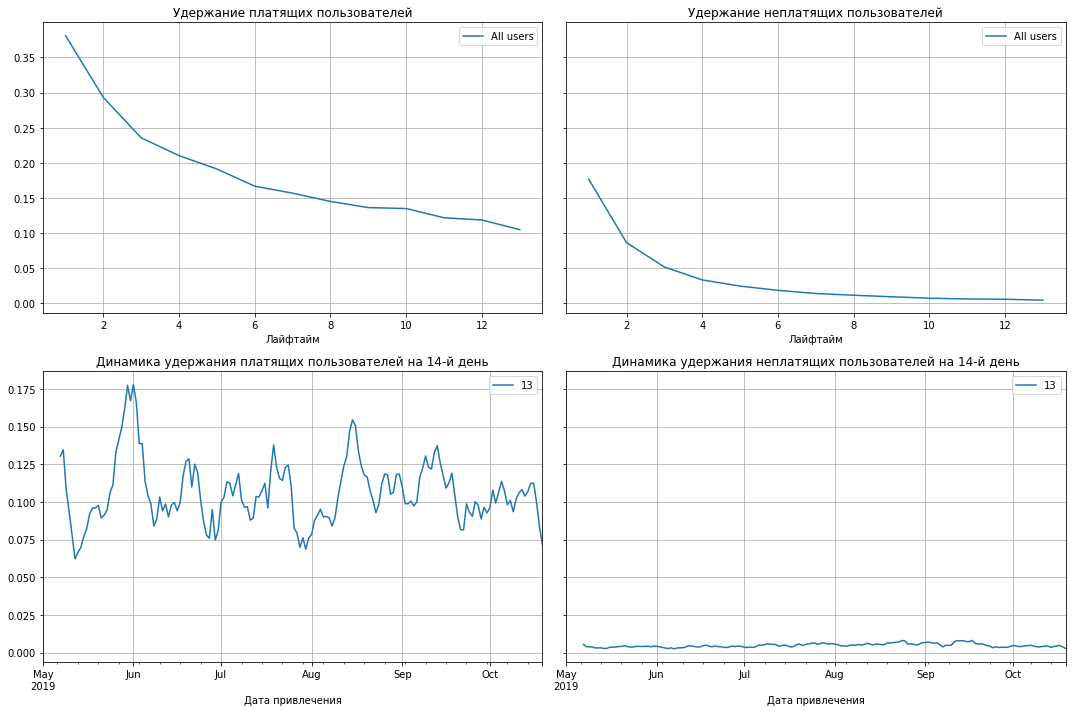

In [50]:
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days)

plot_retention (retention_grouped, retention_history, horizon_days) 

**Выводы по анализу удержания:**

Среди платящих пользователей за 14 дней происходит довольно сильный спад удержания: от 40% в 1-ый день до 10% к 14-му дню.   
Удержание так же колеблется вокруг стабильного уровня на протяжении всего периода.

Предварительная гипотеза: в ходе рекламной активности  привлекается много нецелевых пользователей, которые быстро теряют интерес к сервису.

Рассмотрим более подробно все показатели в разрезах. 

<a id="subart52"></a>
### Оценка окупаемости рекламы по регионам

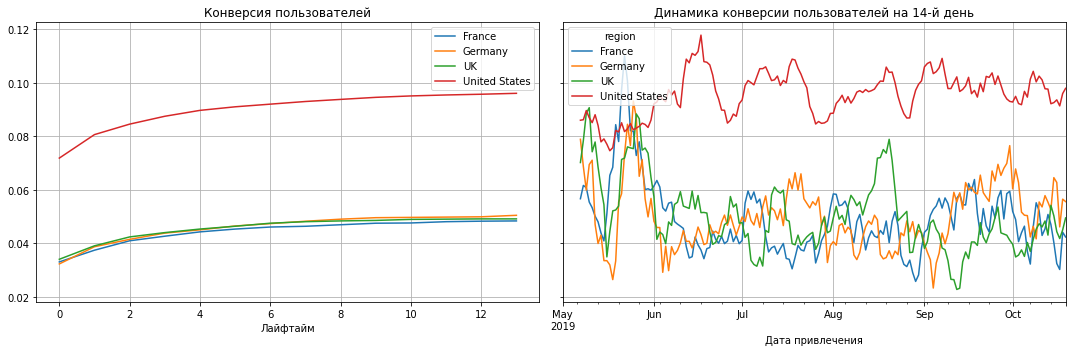

In [51]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, dimensions = ['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

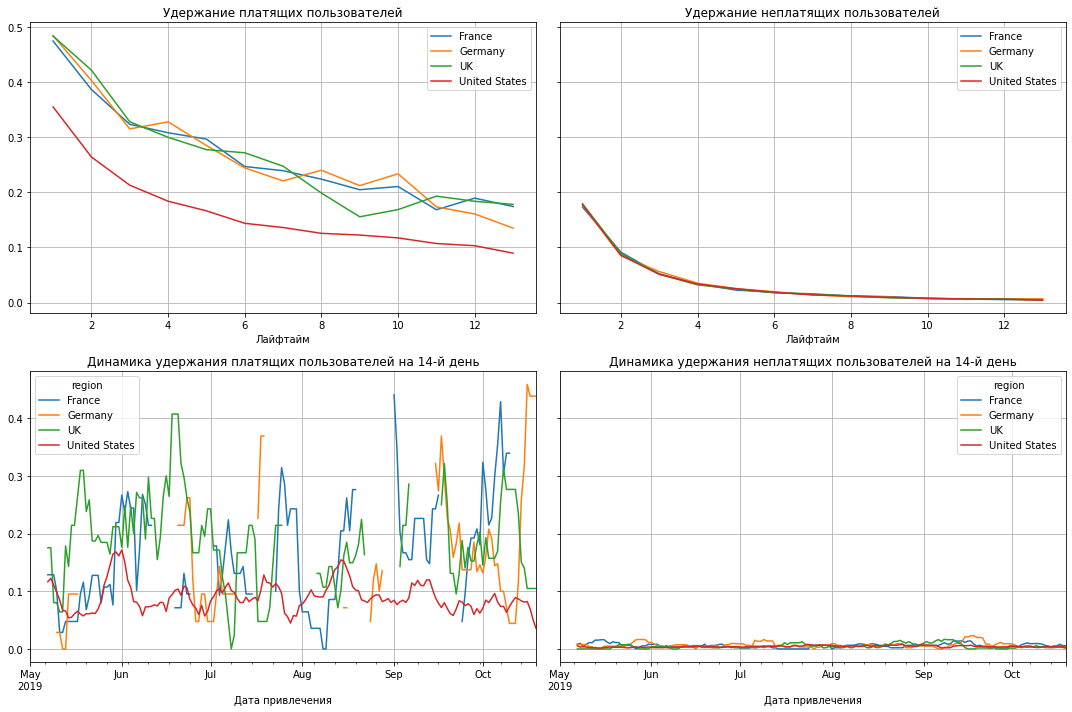

In [52]:
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions = ['region'])

plot_retention (retention_grouped, retention_history, horizon_days) 

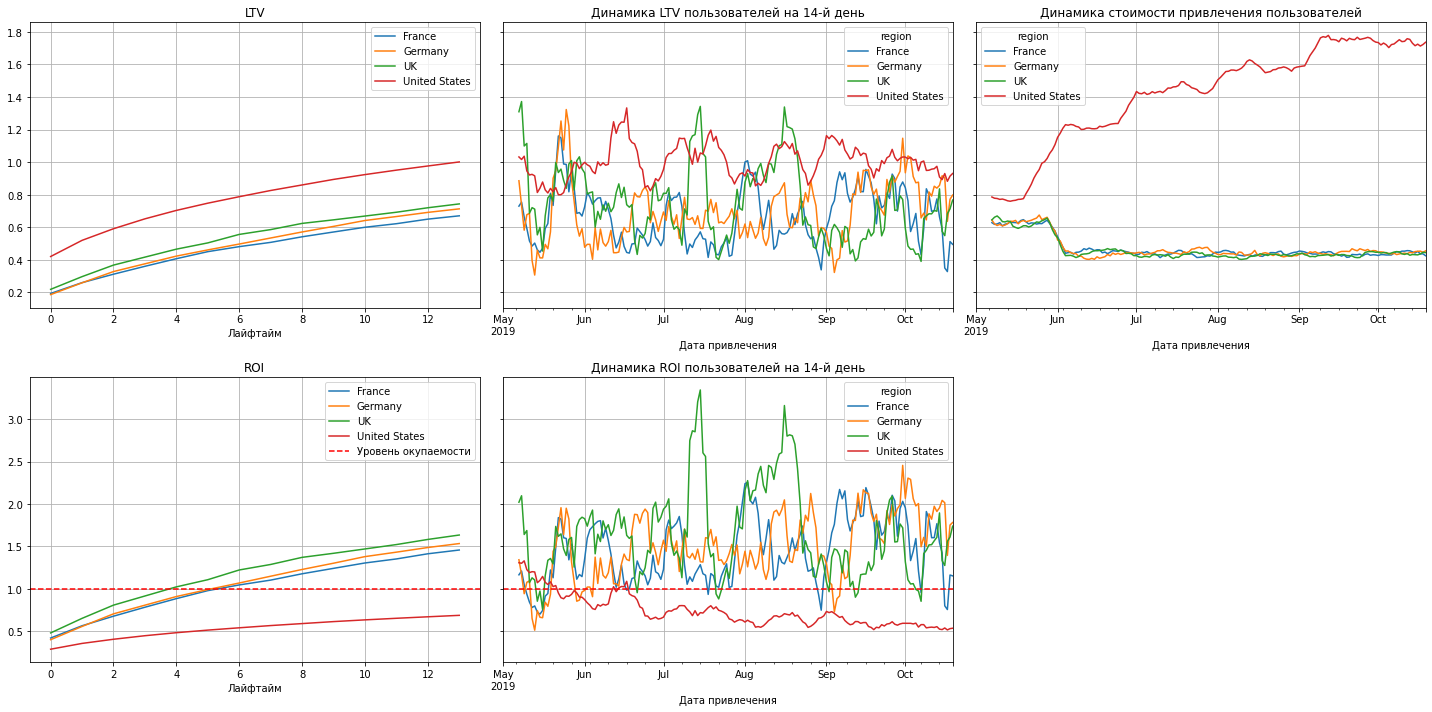

In [53]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = ['region'])

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Выводы по анализу регионов:**

По всем параметрам выделяется рынок США: уровень конверсии и LTV заметно выше, чем по остальным рынкам.   
Ранее мы оценивали долю платящих пользователей: в США она почти вдвое выше чем на других рынках.

Однако, очевидно, что именно в США имело место неэффективное наращивание рекламной активности.    
CAC в США в несколько раз выше остальных рынков и со временем увеличивается.    
ROI ниже уровня окупаемости и продолжает снижаться.    
На европейских рынках инвестиции окупаются в 1.5 раза.

Несмотря на самую лучшую конверсию, удержание в США самое слабое.

<a id="subart53"></a>
### Оценка окупаемости рекламы по устройствам

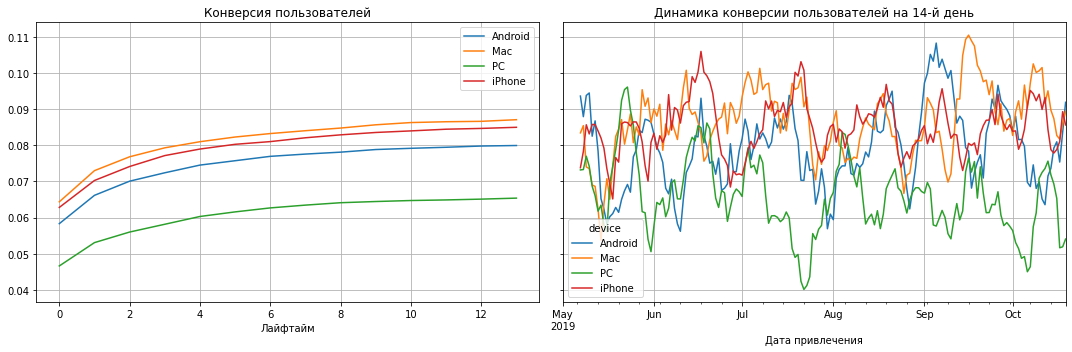

In [54]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, dimensions = ['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

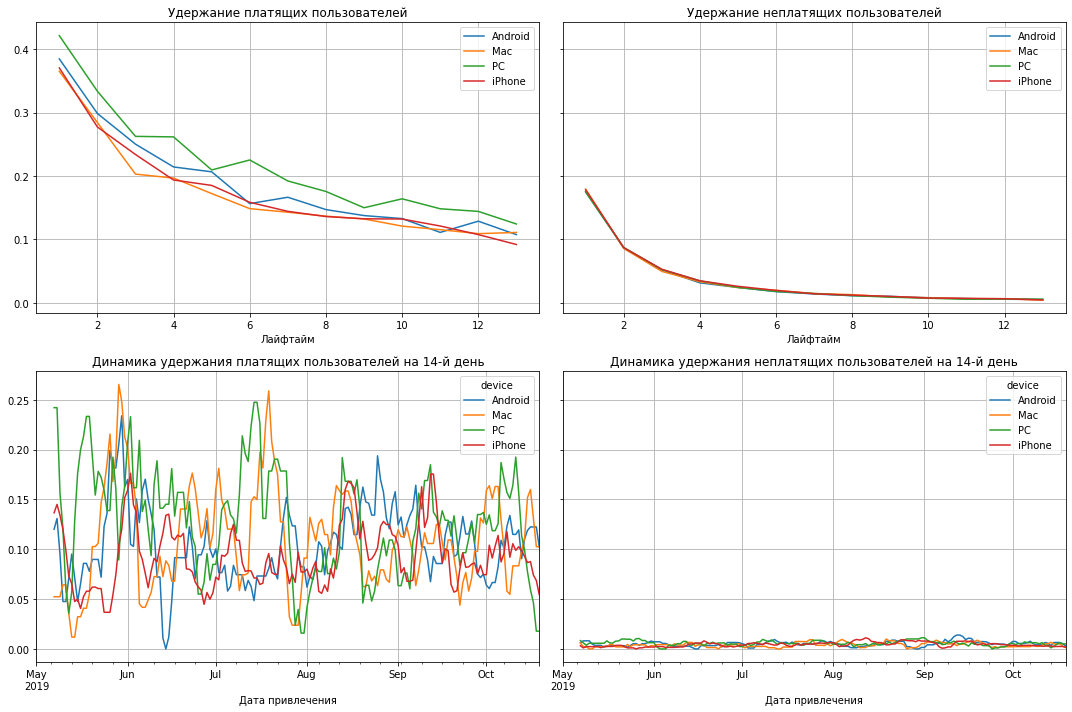

In [55]:
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions = ['device'])

plot_retention (retention_grouped, retention_history, horizon_days) 

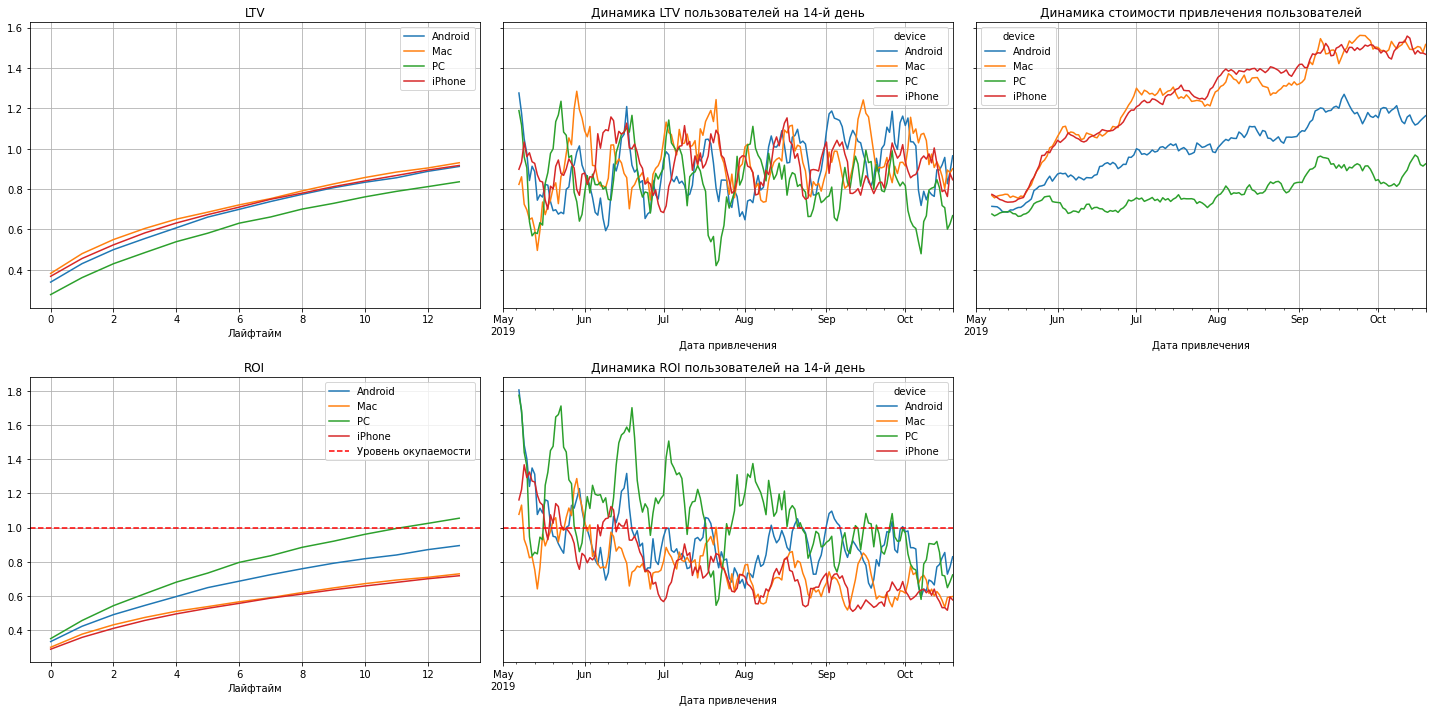

In [56]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = ['device'])

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Выводы по анализу устройств:**

Самый низкий уровень окупаемости у Iphone и Mac.    
Несмотря на высокую конверсию, они явно переинвестированы с точки зрения рекламных усилий.
Наращивание инвестиции в Iphone и Mac является следствием рста инвестиций в США - основная масса пользователей США использует технику аррle.

PC -  с самой низкой конверсией, но лучше других устройств по уровню удержания.   
За счет более оптимально спланированных инвестиций РС единственный среди устройств выходит на окупаемость.

<a id="subart54"></a>
### Оценка окупаемости рекламы по каналам

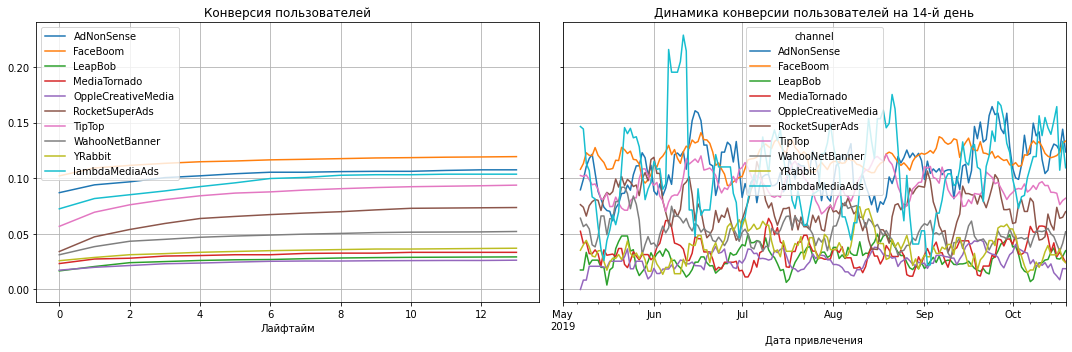

In [63]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, dimensions = ['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

In [64]:
conversion_grouped[13].sort_values(ascending=False).head(5)

channel
FaceBoom          0.119373
AdNonSense        0.107509
lambdaMediaAds    0.103599
TipTop            0.093740
RocketSuperAds    0.073630
Name: 13.0, dtype: float64

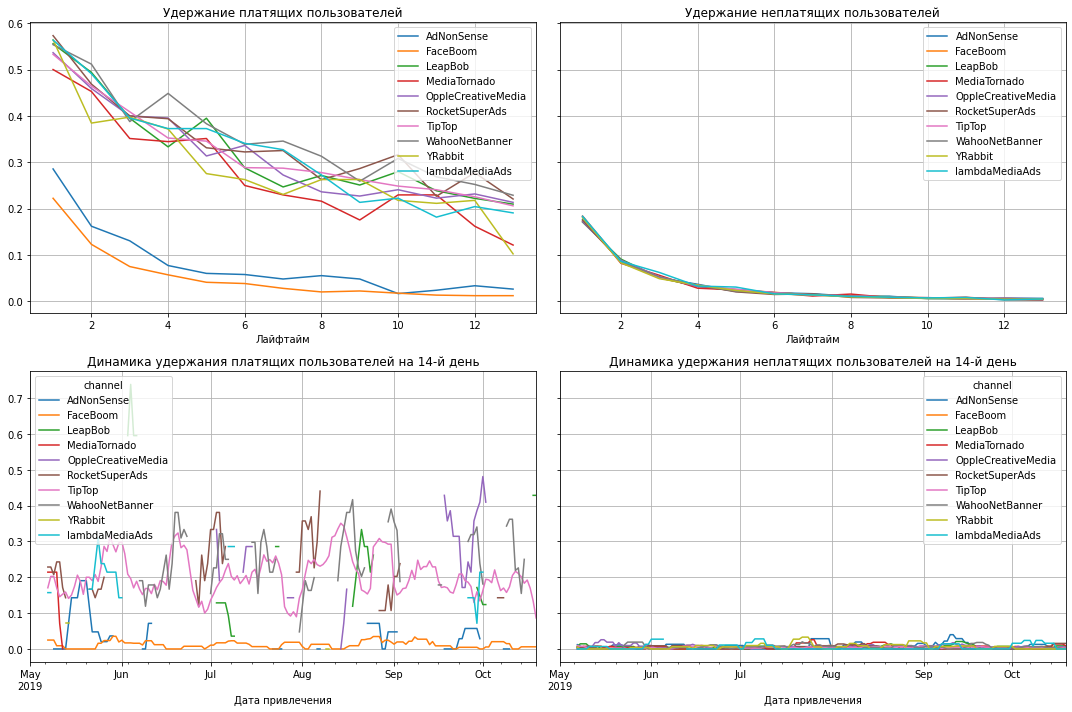

In [65]:
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions = ['channel'])

plot_retention (retention_grouped, retention_history, horizon_days) 

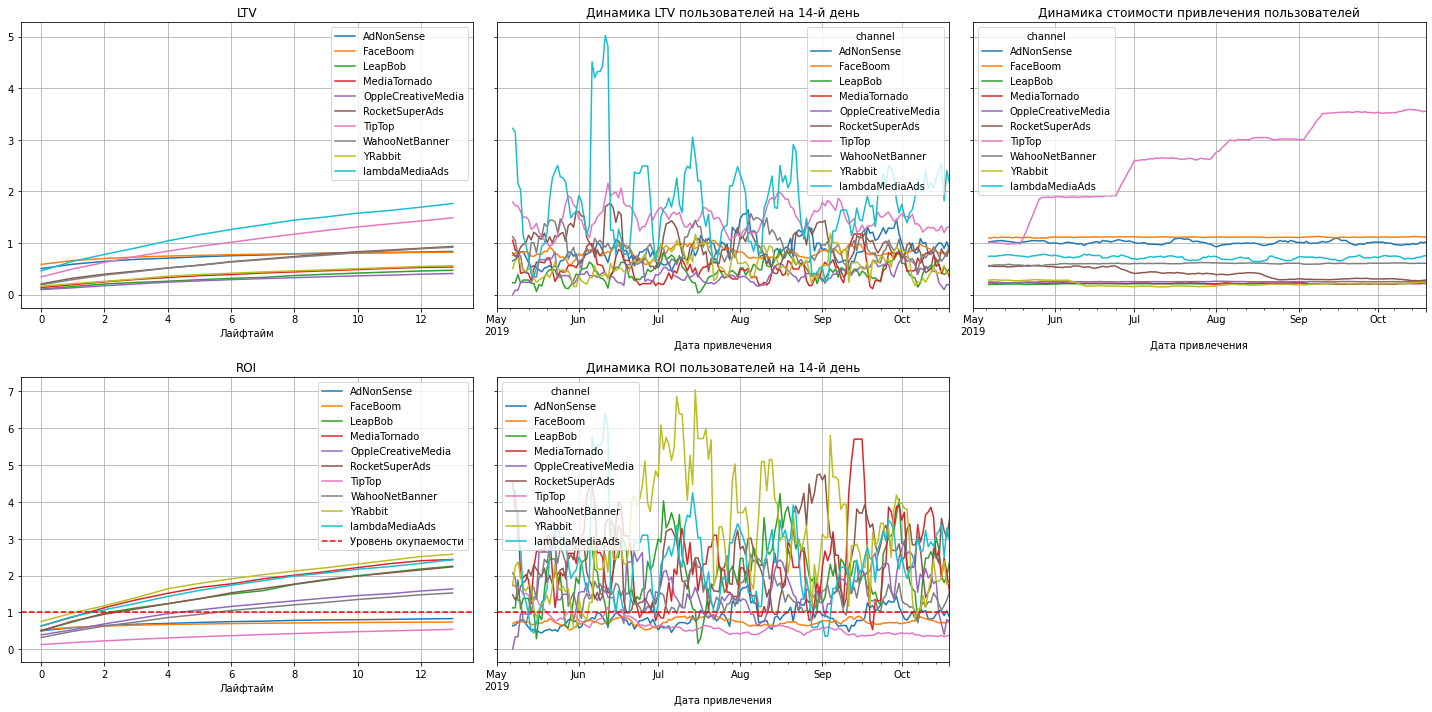

In [66]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = ['channel'])

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

In [61]:
roi_grouped[13].sort_values(ascending = False)

channel
YRabbit               2.578086
MediaTornado          2.436519
lambdaMediaAds        2.428712
LeapBob               2.252399
RocketSuperAds        2.237019
OppleCreativeMedia    1.637075
WahooNetBanner        1.526304
AdNonSense            0.831337
FaceBoom              0.737790
TipTop                0.539532
Name: 13.0, dtype: float64

**Выводы по каналам:**

Среди лидеров по конверсии выделяются несколько каналов: FaceBoom, TipTop, lambdaMediaAds и AdNonSense.    
Эти же каналы являются лидерами по доле платящих клиентов.

FaceBoom и AdNonSense - являются аутсайдерами по удержанию. Похоже, данные площадки привлекают много нецелевых пользователей.   
Для этих каналов может быть рекомендовано проанализировать профиль пользователей с высоким удержанием, и оптимизировать настройки ЦА кампаний в соответствии с данными профилем.

Среди лидеров по конверсии только lambdaMediaAds показывает высокие показатели по ROI.   
FaceBoom, TipTop и AdNonSense находятся ниже порога окупаемости!   
TipTop, наращивая инвестиции, не приносит соответствующего роста пользователей, наращивая Cac.  

<a id="article6"></a>
## Выводы

В ходе анализа были изучены показатели эффективности маркетинга как целиком, так и в разрезах регионов, устройств и каналов привлечения.

Окупаемость приложения падает, на фоне роста рекламных инвестиций.    
Неэффективные инвестиции приводят к росту стоимости привлечения, а увеличения LTV при этим не происходит.

Рост инвестиций с Июня дал дополнительный рост конверсий и LTV. Но одновременно с этим было отмечено снижение удержания. 
Так же с Июня наблюдаем резкий скачок стоимости привлечения пользователей. И снижение окупаемости проекта.
Т.е., очевидно, имело место неэффективности планирование кампании, что привело к существенному снижению показателей финансовой эффективности.

При более детальном анализе было выявлено, что основным источником неэффективных инвестиций был рынок США.   
С одной стороны, усиление инвестиций в США оправдано тем, что в этом регионе самая высокая доля пользователей (66% среди всех рынков), лучшие показатели по конверсии и самая высокая доля платящих пользователей (~7% против ~4% на остальных рынках).     
Однако, анализ показывает, что инвестиции были избыточны (рост инвестиций привел к росту Сac, и ROI ниже порога окупаемости),   
и целевая аудитория выбрана неоптимально (привлеченная аудитория дала высокий отток).  

Так же были выявлены каналы c ROI ниже порога окупаемости: FaceBoom, TipTop и AdNonSense. 
Эти каналы в лидерах по инвестициям: на первые два канала приходится 82% от всех рекламных затрат. 
Решение о больших инвестициях в эти каналы так же обосновано: они являются лидерами по показателям конверсии и доле платящей аудитории. Но на этих каналах требуются существенные оптимизационные меры для роста окупаемости.

Рекомендации по увеличению ROI на этих каналах:
- FaceBoom и AdNonSense - необходима оптимизация профиля целевой аудитории рекламной кампании с целью повышения удержания (у этих каналов самый высокий отток пользователей).
- для этих каналов так же может быть рекомендован ряд мер по повышению удержания и лояльности, например с помощью введения персонализированных UX-стратегий, e-mail рассылок, персональных рекомендаций, push-уведомлений. Можно ввести определённые "награды" или привилегии для постоянных пользователей.  
- также, можно ввести поощрение пользователей за репосты контента и рекомендации приложения в данны каналах.
- TipTop - необходимо снизить рекламные затраты для сохранения показателей по привлеченным пользователей и их качеству, снизив CAC минимум втрое.


Одновременно с этим стоит обратить внимание на другие каналы, такие как lambdaMediaAds - где показатели по конверсии и LTV одни из лучших, и это, кроме того, ещё и лидер по ROI. Необходимо исследовать потенциал по увеличению инвестиций в этот канал с целью общего роста конверсий и LTV.

Разброс показателей эффективности по девайсам носит второстепенный характер и не требует специальных усилий по оптимизации. Ожидаем, что показатели эффективности выровняются естественным образом при внедрении мер по оптимизации на уровне регионов и каналов.